In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import getpass
from hmmlearn import hmm
from functions import *
from random import shuffle
from random import seed
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

### Loading the data

In [2]:
df = pd.read_csv('C:\Users\\'+getpass.getuser()+'\\Google Drive\Sarah Ido folder\data\CCK\MATCHING_phet_cck_user_actions+sophistication_WITHPAUSE_anonymized.txt')
df_scores = pd.read_csv('C:\Users\\'+getpass.getuser()+'\\Google Drive\Sarah Ido folder\data\CCK\MATCHING_phet_cck_user_data_anonymized.txt')
df["student"] = df["student"].astype('category')
df_scores["student"] = df_scores["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()

def remodel_families(row):
    if row["Family"] == "Build" or row["Family"] == "Revise":  # or row["Family"] == "Extra":
        if row["Outcome"] != "None":
            return "ConstructWithFeedback"
        else:
            return "Construct"
    else:
        return row["Family"]
    
df['Family'] = df.apply (lambda row: remodel_families (row),axis=1)

In [3]:
# from pivottablejs import pivot_ui
# pivot_ui(df)

### Some parameters

In [4]:
ACTIONS_TO_REMOVE = ['I','O','S']
ITERS = 300
RAND_INT = 2
seed(RAND_INT)
CUTOFF = 0.01
events = [e for e in ["T","S","O","F","P","I","E","X","C",] if e not in ACTIONS_TO_REMOVE]

### Declaring a few functions

In [5]:
translater = {e:events.index(e) for e in events}
decoder = {events.index(e):e for e in events}

def prepare_data(blocks):
    shuffled_blocks = blocks.values()
    shuffle(shuffled_blocks)
    X = np.array( np.array([np.concatenate([  [int(translater[event]) for event in block.split(' ')] for block in shuffled_blocks])]).T )
    lengths = [len(b.split(' ')) for b in blocks.values()]
    return X, lengths

def split_data(X, lengths, split):
    n_train = int(len(lengths)*split)
    n_test = len(lengths) - n_train
    lengths_train, lengths_test = lengths[0:n_test], lengths[n_test:]
    X_train, X_test = X[0:sum(lengths_train)], X[sum(lengths_train):]
    return X_train, X_test, lengths_train, lengths_test

def get_model(X,lengths,n_states, iters=ITERS, random_state=RAND_INT):
    '''Note that all integers in the range of observations must be present in the data!!'''
    converged = False
    tries = 0
    while converged == False:
        model = hmm.MultinomialHMM(n_components=n_states,
                            n_iter = iters,
                            random_state = random_state).fit(X,lengths)
        converged = model.monitor_.converged
        tries += 1
    print "Model with {0} hidden states converged after {1} tries, with {2} iterations".format(n_states, tries, model.monitor_.iter)
    return model

def make_hmm_graph(model, N, events, cutoff = CUTOFF):

    G = nx.MultiDiGraph()
    G.add_nodes_from(events, node_type = "event")
    G.add_nodes_from(range(N), node_type = "state")

    #Adding edge between hidden states
    for (i,j), p in np.ndenumerate(model.transmat_):
        if p >= cutoff:
            G.add_edge(i,j, weight = p, label="{:.02f}".format(p))

    #Adding emission probabilities: from hidden state to observation
    for (i,j), p in np.ndenumerate(model.emissionprob_):
        if p >= cutoff:
            G.add_edge(i,decoder[j], weight = p, label="{:.02f}".format(p))

    #Can add starting probs eventually
    return G

def plot_hmm_graph(G, N, events, circular_pos = False):
    fig = plt.figure(figsize=(12,7))
    if circular_pos:
        pos = nx.circular_layout(G)
    else:
        pos = {n:np.array([ (n-np.max(range(N))/2.0)/np.max(range(N))*15 ,4+n%2]) for n in range(N)}
        pos.update({e:np.array([   (i-np.max(len(events))/2.0)/np.max(len(events))*15   ,0]) for i,e in enumerate(events)})
    nx.draw_networkx_nodes(G,pos,node_size=700,node_color='#cccccc',alpha=0.8)
    nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels={(k[0],k[1]):round(v,3) for k,v in labels.iteritems()})
    nx.draw_networkx_edges(G,pos)

    cut1 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 20)
    cut2 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 40)
    cut3 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 60)
    cut4 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 80)

    esmall = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= cut1]
    emedium = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut1 and d['weight'] <= cut2]
    elarge = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut2 and d['weight'] <= cut3]
    ehuge = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut3 and d['weight'] <= cut4]
    enormous = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut4]

    colors = ["#c7e9b4","#7fcdbb","#41b6c4","#2c7fb8","#253494"]
    nx.draw_networkx_edges(G,pos,edgelist=esmall,width=3,alpha=1,arros=True,edge_color=colors[0])
    nx.draw_networkx_edges(G,pos,edgelist=emedium,width=3,alpha=1,arros=True,edge_color=colors[1])
    nx.draw_networkx_edges(G,pos,edgelist=elarge,width=3,alpha=1,arros=True,edge_color=colors[2])
    nx.draw_networkx_edges(G,pos,edgelist=ehuge,width=3,alpha=1,arros=True,edge_color=colors[3])
    nx.draw_networkx_edges(G,pos,edgelist=enormous,width=3,alpha=1,arros=True,edge_color=colors[4])

    plt.axis('off')

### Modelling
#### Getting the data
 First, we get the student actions in blocks and keep only the actions we care about. We also build a translator and decoder to pass the actions as discreet integers instead of strings

In [6]:
ACTIVITY = 'a1'
blocks = get_blocks(df[df.Activity==ACTIVITY],get_students(),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)

We concatenate the student actions into one array and computer their lengths. Since the student sequences might be stored in a specific order, we shuffle them first.

In [7]:
X, lengths = prepare_data(blocks)

#### Formatting the data for cross validation
We split the data into a training and test set using a 60/40 % split

In [8]:
X_train, X_test, lengths_train, lengths_test = split_data(X, lengths, 0.6)

We produce the model with the train set using different number of hidden states

In [9]:
scores = []
models = []
n_states = range(1,len(events)+3)
print "Computing HMM model for 39 samples of observations"
for n in n_states:
    %time model = get_model(X_train, lengths_train, n)
    scores.append(model.score(X_test, lengths = lengths_test))
    models.append(model)

Computing HMM model for 39 samples of observations
Model with 1 hidden states converged after 1 tries, with 3 iterations
Wall time: 67 ms
Model with 2 hidden states converged after 1 tries, with 42 iterations
Wall time: 912 ms
Model with 3 hidden states converged after 1 tries, with 62 iterations
Wall time: 1.44 s
Model with 4 hidden states converged after 1 tries, with 73 iterations
Wall time: 1.84 s
Model with 5 hidden states converged after 1 tries, with 95 iterations
Wall time: 2.57 s
Model with 6 hidden states converged after 1 tries, with 98 iterations
Wall time: 2.87 s
Model with 7 hidden states converged after 1 tries, with 79 iterations
Wall time: 2.52 s
Model with 8 hidden states converged after 1 tries, with 170 iterations
Wall time: 5.98 s


#### Now we can plot the scores

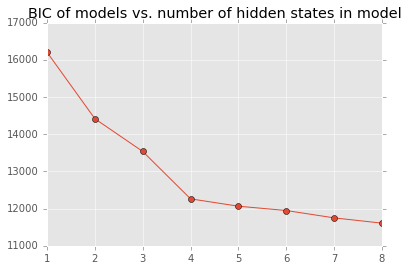

In [10]:
bics = [-2*L + k*np.log(len(X_train)) for L,k in zip(scores, n_states)]
plt.plot(n_states, bics,'-o')
plt.title("BIC of models vs. number of hidden states in model")

### Analysis of model
Given that we want to trade off between the number of hidden states and the information gained, we pick the number of hidden states as 4 (which is where there is an elbow in the plot above). We store the transition and emition probabilities and visualize them. 

**Note**: We only draw edges with an emission or trasnition porbability greater than 0.5% 

In [11]:
N = 4
G = make_hmm_graph(models[N-1], N, events)

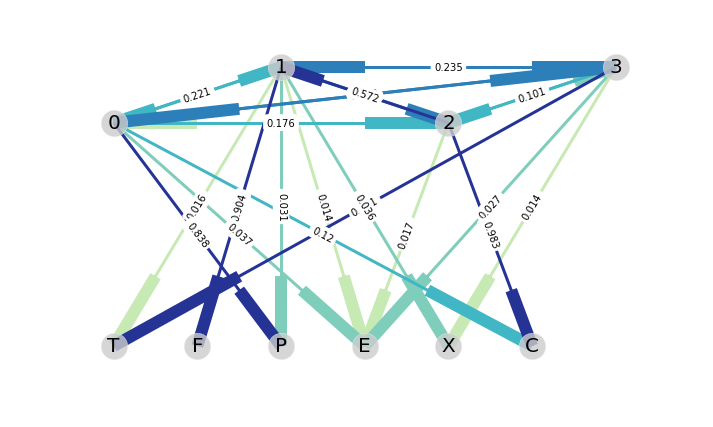

In [12]:
plot_hmm_graph(G, N, events)

Unfortunately, seems like having 4 hidden states creates a pretty boring HMM: each states produces one of the main actions with 0.9 prob or more. So let's go back to 3 states and see what that gives us.

In [13]:
N = 3
G = make_hmm_graph(models[N-1], N, events)

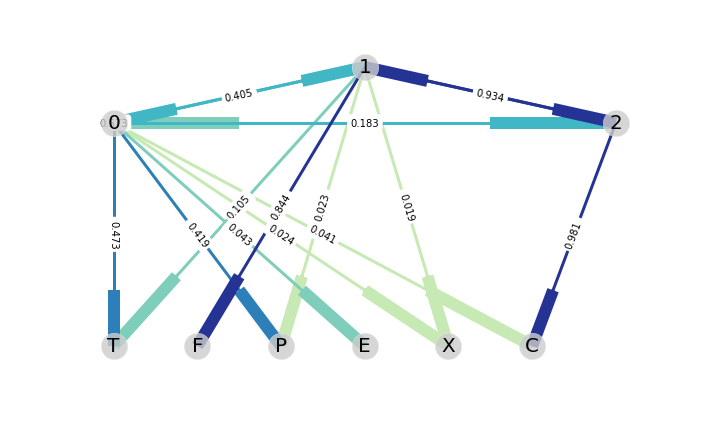

In [14]:
plot_hmm_graph(G, N, events)

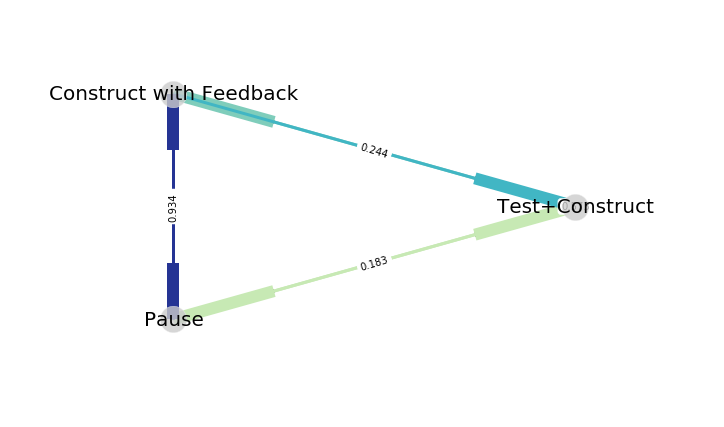

In [15]:
#Alright so we can now assign names to states. Now let's plot only the states
G.remove_nodes_from(events)
G = nx.relabel_nodes(G,mapping= {0:"Test+Construct", 1:"Construct with Feedback",2:"Pause"})
plot_hmm_graph(G, N, events, circular_pos = True)

### Analysis of student groups
Now that we have it all figure it out, we can repeat the process with different groups of students and compare them!

In [18]:
ACTIVITY = 'a1'

blocks_scaff = get_blocks(df[df.Activity==ACTIVITY],get_students("scaffolding","scaff"),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
blocks_not = get_blocks(df[df.Activity==ACTIVITY],get_students("scaffolding","not"),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
X_scaff, lengths_scaff = prepare_data(blocks_scaff)
X_not, lengths_not = prepare_data(blocks_not)

In [19]:
N = 3
model_scaff = get_model(X_scaff, lengths_scaff, N)
model_not = get_model(X_not, lengths_not, N)

Model with 3 hidden states converged after 1 tries, with 66 iterations
Model with 3 hidden states converged after 1 tries, with 70 iterations


In [20]:
print model_scaff.score(X_scaff,lengths_scaff), model_not.score(X_not,lengths_not)

-4762.76744674 -5787.62651608


In [21]:
G_scaff = make_hmm_graph(model_scaff, N, events)
G_not = make_hmm_graph(model_not, N, events)

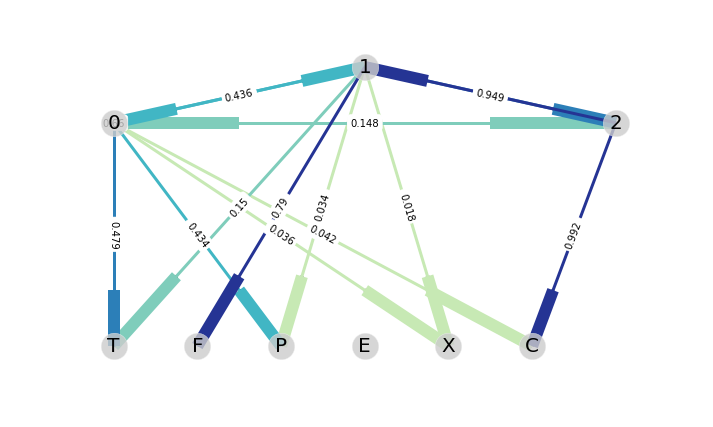

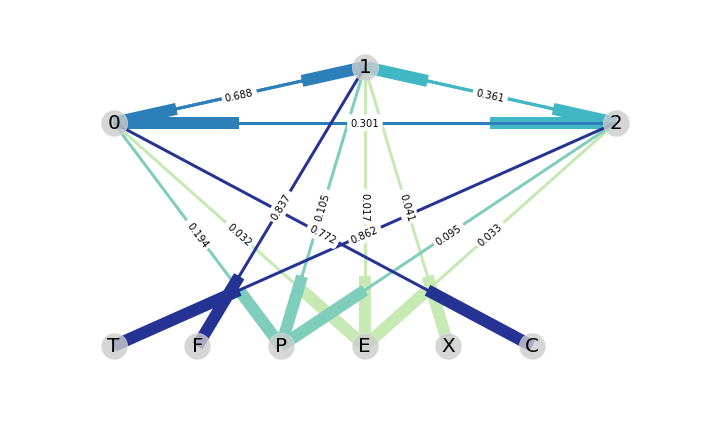

In [22]:
plot_hmm_graph(G_scaff, N, events)
plot_hmm_graph(G_not, N, events)

Clearly, scaffolded students do switch from a state of Test + Pause to Construct with Feedback and later Construct. Not scaffolded students go from a Pause and Construct with Feedback state to Constructing state and occasionaly enter a Testing state.

In [27]:
ACTIVITY = 'a2'

blocks_high = get_blocks(df[df.Activity==ACTIVITY],get_students("learning2","high"),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
blocks_low = get_blocks(df[df.Activity==ACTIVITY],get_students("learning2","low"),add_spaces=True, ignore = ACTIONS_TO_REMOVE, start = False)
X_high, lengths_high = prepare_data(blocks_high)
X_low, lengths_low = prepare_data(blocks_low)

In [29]:
N = 3
model_high = get_model(X_high, lengths_high, N)
model_low = get_model(X_low, lengths_low, N)
print model_high.score(X_high,lengths_high), model_low.score(X_low,lengths_low)

Model with 3 hidden states converged after 1 tries, with 81 iterations
Model with 3 hidden states converged after 1 tries, with 154 iterations
-4439.32220934 -4962.07046555


In [30]:
G_high = make_hmm_graph(model_high, N, events)
G_low = make_hmm_graph(model_low, N, events)

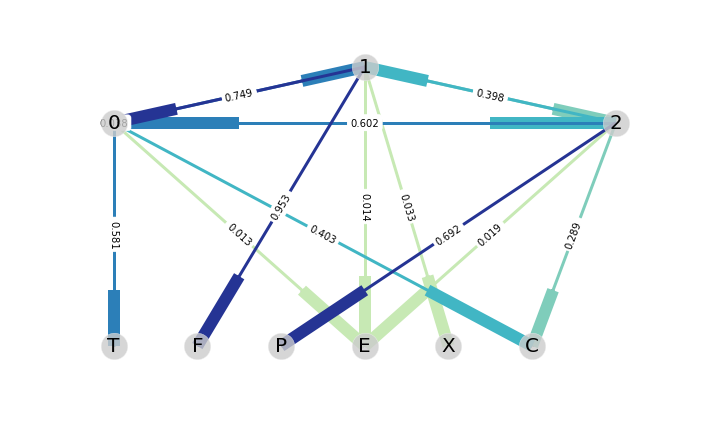

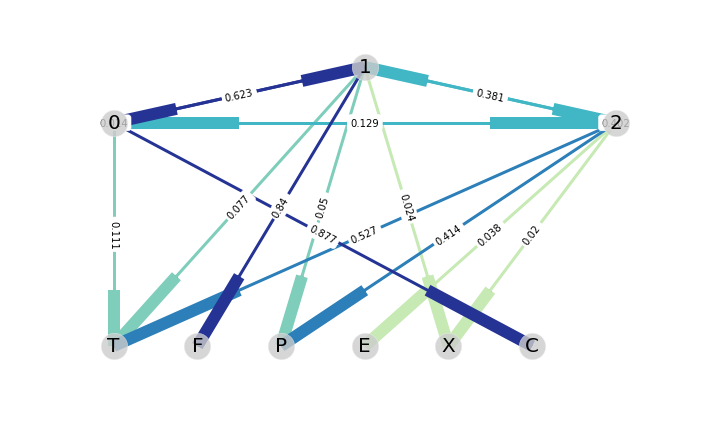

In [31]:
plot_hmm_graph(G_high, N, events)
plot_hmm_graph(G_low, N, events)

In [33]:
model_low.transmat_

array([[  1.41e-02,   8.57e-01,   1.29e-01],
       [  6.23e-01,   7.26e-87,   3.77e-01],
       [  2.17e-01,   3.81e-01,   4.02e-01]])

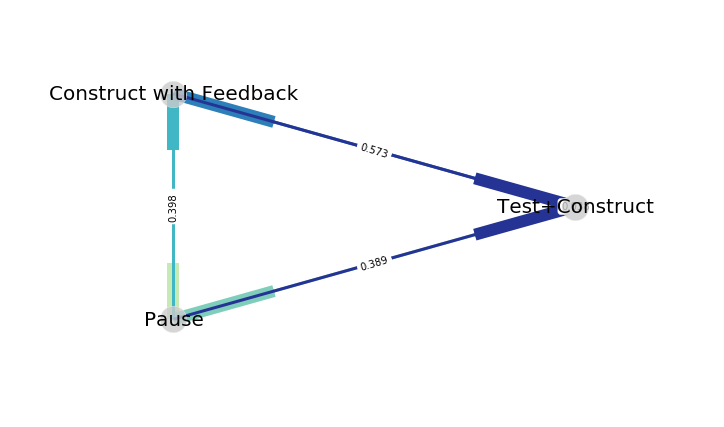

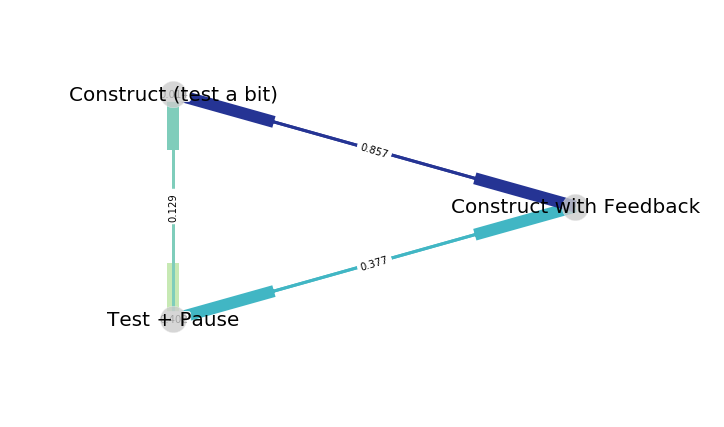

In [35]:
G_high.remove_nodes_from(events)
G_high = nx.relabel_nodes(G_high,mapping= {0:"Test+Construct", 1:"Construct with Feedback",2:"Pause"})
plot_hmm_graph(G_high, N, events, circular_pos = True)
G_low.remove_nodes_from(events)
G_low = nx.relabel_nodes(G_low,mapping= {0:"Construct (test a bit)", 1:"Construct with Feedback",2:"Test + Pause"})
plot_hmm_graph(G_low, N, events, circular_pos = True)